In [3]:
# initial check value
import pandas as pd
import numpy as np
import os
import cv2
from scipy.spatial.transform import Rotation

filename = "hand_eye_calibration"
BASE_DIR = os.getcwd()
data_path = os.path.join(BASE_DIR,filename,f"{filename}.npz")
data = np.load(data_path)

tvecs = data['Target_tvecs']   # [count, id, tx, ty, tz]
rvecs = data['Target_rvecs']   # [count, qx, qy, qz, qw]
gripper_pose = data['gripper_pose']  # [x, y, z, qx, qy, qz, qw]

# target_ : target2cam value / tvec : x,y,z (m), / rvec : rx, ry, rz (Rodrigues, rad)
# gripper_ : base2gipper value / tvec : x,y,z (m) / rvec : qx, qy, qz, qw (quaternion)
eyehand_data = pd.DataFrame({
    'count': tvecs[:, 0].astype(int),
    'id': tvecs[:, 1].astype(int),
    'target_tvec_x': tvecs[:, 2],
    'target_tvec_y': tvecs[:, 3],
    'target_tvec_z': tvecs[:, 4],
    'target_rvec_rx': rvecs[:, 1],
    'target_rvec_ry': rvecs[:, 2],
    'target_rvec_rz': rvecs[:, 3],
    'gripper_x': gripper_pose[:, 0],
    'gripper_y': gripper_pose[:, 1],
    'gripper_z': gripper_pose[:, 2],
    'gripper_qx': gripper_pose[:, 3],
    'gripper_qy': gripper_pose[:, 4],
    'gripper_qz': gripper_pose[:, 5],
    'gripper_qw': gripper_pose[:, 6],
})

# --- 변환행렬 함수 정의 ---

def quat_tvec_to_matrix(quat):
    # quat : [qx, qy, qz, qw] (quaternion)
    # rotation matrix (3x3)
    R = Rotation.from_quat(quat).as_matrix()

    return R

def rvec_tvec_to_matrix(rvec):
    #rvec : [rx, ry, rz]  (Rodrigues rotation vector)
    rvec = np.array(rvec).reshape(3, 1)
    # Rodrigues → rotation matrix
    R, _ = cv2.Rodrigues(rvec)

    return R

def invert_R_t(R, t):
    """
    R: 3x3 rotation matrix (numpy array)
    t: 3x1 translation vector (numpy array)
    
    returns:
        R_inv, t_inv  (rotation + translation of T_{B->A})
    """
    R_inv = R.T                 # R^T
    t_inv = - R_inv @ t         # -R^T * t
    return R_inv, t_inv

R_target2cam_list = []
t_target2cam_list = []
R_gripper2base_list = []
t_gripper2base_list = []

for i in range(len(eyehand_data)):
    # camera 측정값 (rvec, tvec)
    target_rvec = eyehand_data.loc[i, ['target_rvec_rx', 'target_rvec_ry', 'target_rvec_rz']].values
    target_tvec = eyehand_data.loc[i, ['target_tvec_x', 'target_tvec_y', 'target_tvec_z']].values
    target_rvec_mat= rvec_tvec_to_matrix(target_rvec)
    R_target2cam_list.append(target_rvec_mat)
    t_target2cam_list.append(target_tvec.reshape(3,1))

    # gripper pose 측정값 (rvec, tvec)
    x, y, z, qx, qy, qz, qw = eyehand_data.loc[i,
        ['gripper_x','gripper_y','gripper_z',
         'gripper_qx','gripper_qy','gripper_qz','gripper_qw']].values
    quat_grip = np.array([qx, qy, qz, qw])
    tvec_grip = np.array([x, y, z]).reshape(3,1)
    quat_grip_mat = quat_tvec_to_matrix(quat_grip)
    R_gripper2base_list.append(quat_grip_mat)
    t_gripper2base_list.append(tvec_grip)


# num = 0
# print("R_target2cam_list\n", R_target2cam_list[num])
# print("t_target2cam_list\n", t_target2cam_list[num])
# print("R_gripper2base_list\n", R_gripper2base_list[num])
# print("t_gripper2base_list\n", t_gripper2base_list[num])

# print("aruco tvec raw: ", eyehand_data[['target_tvec_x','target_tvec_y','target_tvec_z']].head())
# print("gripper pose raw:", eyehand_data[['gripper_x','gripper_y','gripper_z']].head())

# OpenCV Hand-Eye Calibration 수행
R_cam2gripper, t_cam2gripper = cv2.calibrateHandEye(
    R_gripper2base_list, t_gripper2base_list,
    R_target2cam_list, t_target2cam_list,
    method=cv2.CALIB_HAND_EYE_TSAI
)

# 결과 변환행렬 생성
T_cam2gripper = np.eye(4)
T_cam2gripper[:3, :3] = R_cam2gripper
T_cam2gripper[:3, 3] = t_cam2gripper.reshape(3)

# 역행렬로 Tgripper→cam도 계산
T_gripper2cam = np.linalg.inv(T_cam2gripper)

print("===== Hand-Eye Calibration Result =====")
print(f"param file name : {filename}")
print("R_cam2gripper:\n", R_cam2gripper)
print("t_cam2gripper [m]:\n", t_cam2gripper)
print("\nT_cam2gripper:\n", T_cam2gripper)
print("\nT_gripper2cam:\n", T_gripper2cam)

===== Hand-Eye Calibration Result =====
param file name : hand_eye_calibration
R_cam2gripper:
 [[-0.09837893  0.1606406   0.98209785]
 [-0.99123926 -0.10321322 -0.08241218]
 [ 0.08812674 -0.98160156  0.16938727]]
t_cam2gripper [m]:
 [[-0.05113446]
 [-0.0067561 ]
 [ 0.04876112]]

T_cam2gripper:
 [[-0.09837893  0.1606406   0.98209785 -0.05113446]
 [-0.99123926 -0.10321322 -0.08241218 -0.0067561 ]
 [ 0.08812674 -0.98160156  0.16938727  0.04876112]
 [ 0.          0.          0.          1.        ]]

T_gripper2cam:
 [[-0.09837893 -0.99123926  0.08812674 -0.01602462]
 [ 0.1606406  -0.10321322 -0.98160156  0.05538094]
 [ 0.98209785 -0.08241218  0.16938727  0.04140274]
 [ 0.          0.          0.          1.        ]]


In [4]:
eyehand_data.shape

(56, 15)

In [5]:
eyehand_data['id'].unique()

array([1])

In [6]:
eyehand_data['count']

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
36    37
37    38
38    39
39    40
40    41
41    42
42    43
43    44
44    45
45    46
46    47
47    48
48    49
49    50
50    51
51    52
52    53
53    54
54    55
55    56
Name: count, dtype: int64

/tmp/ipykernel_225724/200663713.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tx, ty, tz, rx, ry, rz, g_tx, g_ty, g_tz, g_qx, g_qy, g_qz, g_qw],


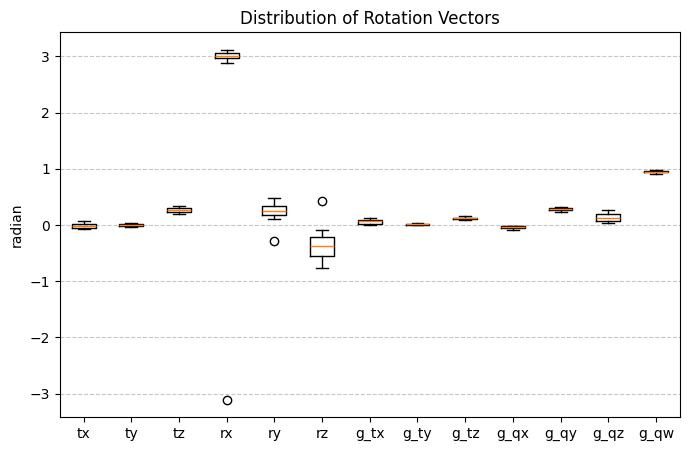

In [8]:
import matplotlib.pyplot as plt
import numpy as np

tx = tvecs[:, 2]
ty = tvecs[:, 3]
tz = tvecs[:, 4]
rx = rvecs[:, 1]
ry = rvecs[:, 2]
rz = rvecs[:, 3]
g_tx = gripper_pose[:, 0]
g_ty = gripper_pose[:, 1]
g_tz = gripper_pose[:, 2]
g_qx = gripper_pose[:, 3]
g_qy = gripper_pose[:, 4]
g_qz = gripper_pose[:, 5]
g_qw = gripper_pose[:, 6]

# boxplot 생성
plt.figure(figsize=(8, 5))
plt.boxplot([tx, ty, tz, rx, ry, rz, g_tx, g_ty, g_tz, g_qx, g_qy, g_qz, g_qw], 
            labels=['tx', 'ty', 'tz','rx', 'ry', 'rz', 'g_tx', 'g_ty', 'g_tz', 'g_qx', 'g_qy', 'g_qz', 'g_qw'])
plt.title('Distribution of Rotation Vectors')
plt.ylabel('radian')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

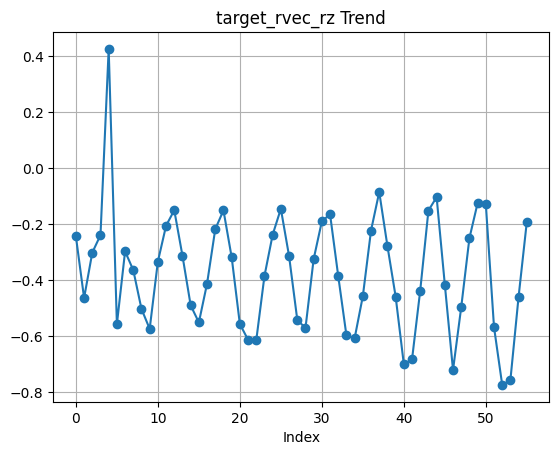

In [16]:
name = 'target_rvec_rz'
eyehand_data[f'{name}']

plt.plot(eyehand_data[f'{name}'], marker='o')
plt.title(f'{name} Trend')
plt.xlabel('Index')
plt.grid(True)
plt.show()

In [17]:
rx_outlier = (eyehand_data['target_rvec_rx'] < 0).sum()
ty_outlier = (eyehand_data['target_rvec_ry'] < 0).sum()
tz_outlier = (eyehand_data['target_rvec_rz'] > 0).sum()
print(f"ty: {ty_outlier}", f"tz: {tz_outlier}", f"rx: {rx_outlier}")

ty: 1 tz: 1 rx: 1


In [18]:
rx_outliers = eyehand_data.loc[eyehand_data['target_rvec_rx'] < 0, 'count']
ty_outliers = eyehand_data.loc[eyehand_data['target_rvec_ry'] < 0, 'count']
tz_outliers = eyehand_data.loc[eyehand_data['target_rvec_rz'] > 0, 'count']

print("ty outliers:", list(ty_outliers))
print("tz outliers:", list(tz_outliers))
print("rx outliers:", list(rx_outliers))


ty outliers: [5]
tz outliers: [5]
rx outliers: [5]


In [31]:
eyehand_data.loc[4]

count             5.000000
id                1.000000
target_tvec_x    -0.002457
target_tvec_y    -0.010769
target_tvec_z     0.194345
target_rvec_rx   -3.110839
target_rvec_ry   -0.287434
target_rvec_rz    0.425195
gripper_x         0.120604
gripper_y         0.032780
gripper_z         0.098930
gripper_qx       -0.048311
gripper_qy        0.327254
gripper_qz        0.137820
gripper_qw        0.933583
Name: 4, dtype: float64

In [44]:
# 1️⃣ id == 1 인 데이터만 필터링
eyehand_refined = eyehand_data[eyehand_data['count'] != 5].copy()
eyehand_refined = eyehand_refined.reset_index(drop=True)

# 4️⃣ 결과 확인
print("✅ Refined data shape:", eyehand_refined.shape)
print(eyehand_refined.head())

✅ Refined data shape: (55, 15)
   count  id  target_tvec_x  target_tvec_y  target_tvec_z  target_rvec_rx  \
0      1   1      -0.050252       0.020839       0.300204        3.082963   
1      2   1       0.009028       0.000109       0.193168        3.065573   
2      3   1      -0.022923       0.007766       0.198542        3.067998   
3      4   1      -0.036898      -0.008299       0.193942        3.113760   
4      6   1       0.025275      -0.007018       0.193302        3.059171   

   target_rvec_ry  target_rvec_rz  gripper_x  gripper_y  gripper_z  \
0        0.165209       -0.243776   0.043921   0.005290   0.168097   
1        0.314750       -0.463741   0.123058   0.038417   0.108200   
2        0.227677       -0.301740   0.126062   0.026732   0.108946   
3        0.200124       -0.239236   0.124015   0.020333   0.101305   
4        0.341314       -0.557408   0.116775   0.043611   0.099442   

   gripper_qx  gripper_qy  gripper_qz  gripper_qw  
0   -0.025824    0.313807    0.07

/tmp/ipykernel_57895/857304635.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tx, ty, tz, rx, ry, rz, g_tx, g_ty, g_tz, g_qx, g_qy, g_qz, g_qw],


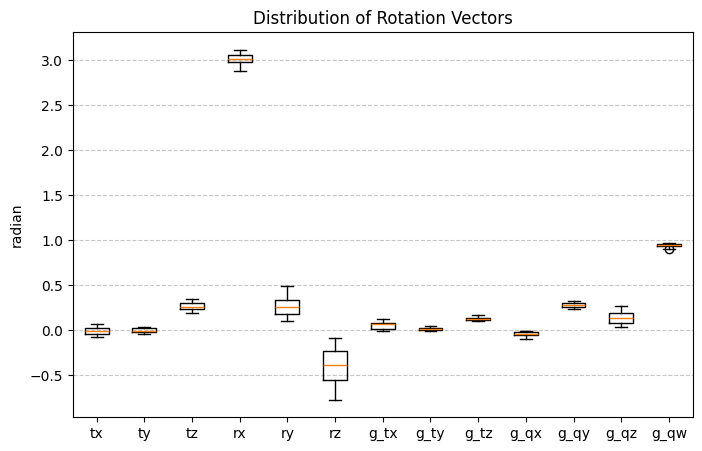

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# boxplot 생성
tx = eyehand_refined['target_tvec_x']
ty = eyehand_refined['target_tvec_y']
tz = eyehand_refined['target_tvec_z']
rx = eyehand_refined['target_rvec_rx']
ry = eyehand_refined['target_rvec_ry']
rz = eyehand_refined['target_rvec_rz']
g_tx = eyehand_refined['gripper_x']
g_ty = eyehand_refined['gripper_y']
g_tz = eyehand_refined['gripper_z']
g_qx = eyehand_refined['gripper_qx']
g_qy = eyehand_refined['gripper_qy']
g_qz = eyehand_refined['gripper_qz']
g_qw = eyehand_refined['gripper_qw']
# boxplot 생성
plt.figure(figsize=(8, 5))
plt.boxplot([tx, ty, tz, rx, ry, rz, g_tx, g_ty, g_tz, g_qx, g_qy, g_qz, g_qw], 
            labels=['tx', 'ty', 'tz','rx', 'ry', 'rz', 'g_tx', 'g_ty', 'g_tz', 'g_qx', 'g_qy', 'g_qz', 'g_qw'])
plt.title('Distribution of Rotation Vectors')
plt.ylabel('radian')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [47]:

# --- 변환행렬 함수 정의 ---

def quat_tvec_to_matrix(quat):
    # quat : [qx, qy, qz, qw] (quaternion)
    # rotation matrix (3x3)
    R = Rotation.from_quat(quat).as_matrix()

    return R

def rvec_tvec_to_matrix(rvec):
    #rvec : [rx, ry, rz]  (Rodrigues rotation vector)
    rvec = np.array(rvec).reshape(3, 1)
    # Rodrigues → rotation matrix
    R, _ = cv2.Rodrigues(rvec)

    return R

def invert_R_t(R, t):
    """
    R: 3x3 rotation matrix (numpy array)
    t: 3x1 translation vector (numpy array)
    
    returns:
        R_inv, t_inv  (rotation + translation of T_{B->A})
    """
    R_inv = R.T                 # R^T
    t_inv = - R_inv @ t         # -R^T * t
    return R_inv, t_inv

R_target2cam_list = []
t_target2cam_list = []
R_gripper2base_list = []
t_gripper2base_list = []

for i in range(len(eyehand_refined)):
    # camera 측정값 (rvec, tvec)
    target_rvec = eyehand_refined.loc[i, ['target_rvec_rx', 'target_rvec_ry', 'target_rvec_rz']].values
    target_tvec = eyehand_refined.loc[i, ['target_tvec_x', 'target_tvec_y', 'target_tvec_z']].values
    target_rvec_mat= rvec_tvec_to_matrix(target_rvec)
    R_target2cam_list.append(target_rvec_mat)
    t_target2cam_list.append(target_tvec.reshape(3,1))

    # gripper pose 측정값 (rvec, tvec)
    x, y, z, qx, qy, qz, qw = eyehand_refined.loc[i,
        ['gripper_x','gripper_y','gripper_z',
         'gripper_qx','gripper_qy','gripper_qz','gripper_qw']].values
    quat_grip = np.array([qx, qy, qz, qw])
    tvec_grip = np.array([x, y, z]).reshape(3,1)
    quat_grip_mat = quat_tvec_to_matrix(quat_grip)
    R_gripper2base_list.append(quat_grip_mat)
    t_gripper2base_list.append(tvec_grip)


# num = 0
# print("R_target2cam_list\n", R_target2cam_list[num])
# print("t_target2cam_list\n", t_target2cam_list[num])
# print("R_gripper2base_list\n", R_gripper2base_list[num])
# print("t_gripper2base_list\n", t_gripper2base_list[num])

# print("aruco tvec raw: ", eyehand_refined[['target_tvec_x','target_tvec_y','target_tvec_z']].head())
# print("gripper pose raw:", eyehand_refined[['gripper_x','gripper_y','gripper_z']].head())

# OpenCV Hand-Eye Calibration 수행
R_cam2gripper, t_cam2gripper = cv2.calibrateHandEye(
    R_gripper2base_list, t_gripper2base_list,
    R_target2cam_list, t_target2cam_list,
    method=cv2.CALIB_HAND_EYE_TSAI
)

# 결과 변환행렬 생성
T_cam2gripper = np.eye(4)
T_cam2gripper[:3, :3] = R_cam2gripper
T_cam2gripper[:3, 3] = t_cam2gripper.reshape(3)

# 역행렬로 Tgripper→cam도 계산
T_gripper2cam = np.linalg.inv(T_cam2gripper)

print("===== Hand-Eye Calibration Result =====")
print(f"param file name : {filename}")
print("R_cam2gripper:\n", R_cam2gripper)
print("t_cam2gripper [m]:\n", t_cam2gripper)
print("\nT_cam2gripper:\n", T_cam2gripper)
print("\nT_gripper2cam:\n", T_gripper2cam)

===== Hand-Eye Calibration Result =====
param file name : hand_eye_calibration
R_cam2gripper:
 [[-0.09837893  0.1606406   0.98209785]
 [-0.99123926 -0.10321322 -0.08241218]
 [ 0.08812674 -0.98160156  0.16938727]]
t_cam2gripper [m]:
 [[-0.05113446]
 [-0.0067561 ]
 [ 0.04876112]]

T_cam2gripper:
 [[-0.09837893  0.1606406   0.98209785 -0.05113446]
 [-0.99123926 -0.10321322 -0.08241218 -0.0067561 ]
 [ 0.08812674 -0.98160156  0.16938727  0.04876112]
 [ 0.          0.          0.          1.        ]]

T_gripper2cam:
 [[-0.09837893 -0.99123926  0.08812674 -0.01602462]
 [ 0.1606406  -0.10321322 -0.98160156  0.05538094]
 [ 0.98209785 -0.08241218  0.16938727  0.04140274]
 [ 0.          0.          0.          1.        ]]
